In [1]:
%matplotlib inline
%load_ext tensorboard
import math
import os
from itertools import count, groupby
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.distributions import Bernoulli, Normal
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from pytorch_lightning import LightningModule, Trainer

In [2]:
class GaussianDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(nn.Linear(20, 100),
                                     nn.ReLU(),
                                     nn.Linear(100, 200),
                                     nn.ReLU(),
                                     nn.Linear(200, 400),
                                     nn.ReLU(),
                                     nn.Linear(400, 784),
                                     nn.ReLU())
        self.mu = nn.Linear(784, 784)
        self.logvar = nn.Linear(784, 784)
    
    def forward(self, z):
        h = self.decoder(z)
        return self.mu(h), self.logvar(h)

In [3]:
class BetaTCVAE(nn.Module):
    """beta-TC class VAE

    Parameters
    ----------
    encoder : torch.nn.Module
    decoder : torch.nn.Module
        pytorch networks used to encode and decode to/from the latent variables
    e : int
        The output dimension of the encoder network
    z : int
        The input dimension of the decoder network
    beta : int
        Total Correlation weight term (default=1)
    lamb : float in [0, 1]
        Dimension wise KL term is (1 - lamb)
    """
    def __init__(self, encoder, decoder, e, z, beta=1, lamb=0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.e_dim = e
        self.z_dim = z
        self.beta = beta
        self.lamb = lamb
        # Learned Z Hyperparams
        # Q: Why logvar and not stddev?
        # A: https://stats.stackexchange.com/a/353222
        self.mu = nn.Linear(e, z)
        self.logvar = nn.Linear(e, z)

    def encode(self, x):
        """Hook for reparameterizing the outs of the encoder"""
        h = self.encoder(x)
        mu = self.mu(h)
#         std = torch.exp(0.5*self.logvar(h))
        std = F.softplus(self.logvar(h))
        eps = torch.randn_like(std)
        z = mu + std*eps
        return z, mu, std

    def get_xdist(self, z):
        """Hook for customising interpretation of decoder output"""
        # using GaussianDecoder
        mu, logvar = self.decoder(z)
        std = F.softplus(logvar)
        return Normal(mu, std)
#         return Bernoulli(logits=self.decoder(z))

    def get_pdist(self, z):
        """Hook to customize prior distribution"""
        return Normal(torch.zeros_like(z), torch.ones_like(z))

    def get_qdist(self, mu, std):
        """Hook to customize construction of qdist from mean and stddev"""
        return Normal(mu, std)

    def forward(self, x, dataset_size):
        """Calculates the Evidence Lower Bound (ELBO) of the VAE on x"""
        x_len = x.shape[0]
        z, mu, std = self.encode(x)
        
        # log(p(x))
        xdist = self.get_xdist(z)
        logpx = xdist.log_prob(x).sum(1)

        # log(p(z))
        pdist = self.get_pdist(z)
        logpz = pdist.log_prob(z).sum(1)

        # log(q(z|x))
        qdist = self.get_qdist(mu, std)
        logqz_condx = qdist.log_prob(z).sum(1)

        # Calculate matrix of shape (x_len, x_len, z_dim) which contains the
        # log probability of each instance's latent variables under the
        # distributions of every instance latent vars in the batch
        qdist = qdist.expand((1, x_len, self.z_dim))
        qzmat = qdist.log_prob(z.view(x_len, 1, self.z_dim))

        # log(q(z)) via minibatch weighted sampling
        logmn = math.log(dataset_size * x_len)
        logqz = torch.logsumexp(qzmat.sum(2), dim=1) - logmn
        logqz_prodmarginals = (torch.logsumexp(qzmat, dim=1) - logmn).sum(1)

        # Calculate Modified ELBO:
        # Basic ELBO is just logpx + logpz - logqz_condx
        ix_code_mi = logqz_condx - logqz
        total_corr = self.beta * (logqz - logqz_prodmarginals)
        dimwise_kl = (1 - self.lamb) * (logqz_prodmarginals - logpz)
        modified_elbo = logpx - ix_code_mi - total_corr - dimwise_kl
        return modified_elbo

In [4]:
class MnistBTCVAE(LightningModule):
    def __init__(self, beta=1):
        super().__init__()
        e = 100
        z = 20
        encoder = nn.Sequential(nn.Linear(784, 400),
                                nn.ReLU(),
                                nn.Linear(400, 200),
                                nn.ReLU(),
                                nn.Linear(200, e),
                                nn.ReLU())
        decoder = GaussianDecoder()
        self.beta_tcvae = BetaTCVAE(encoder, decoder, e, z, beta)
        
    def prepare_data(self):
        # Downloads if necessary
        MNIST(os.getcwd(), train=True, download=True)
        
    def train_dataloader(self):
        # No download, get mnist from disk
        data = MNIST(os.getcwd(), transform=ToTensor())
        return DataLoader(data, batch_size=128)
    
    def forward(self, x):
        return self.beta_tcvae(x, 60_000)
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.view(X.shape[0], -1)
        loss = self.forward(X).mul(-1).mean()
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

In [5]:
model = MnistBTCVAE()

trainer = Trainer(max_epochs=10)
trainer.fit(model)

1

In [18]:
@torch.no_grad()
def get_digit_samples():
    by_digit = itemgetter(1)

    mnist = MNIST(os.getcwd(), transform=ToTensor())
    mnist = sorted(mnist, key=by_digit)
    mnist = groupby(mnist, key=by_digit)

    samples = []
    for digit, grp in mnist:
        x, y = next(grp)
        samples.append(x.view(-1))

    return torch.stack(samples)


@torch.no_grad()
def sweep_variable_across_samples(vae, samples, i, sweep):
    """Sweeps a single latent variable
    
    Arguments
    ---------
    vae : torch.Module
        A VAE module; must have a decode method
    samples : n-by-z array-like
        Contains n samples of z latent variables
    i : int < z
        The latent variable to sweep
    sweep : array
        The values to use in sweeping z
    """
    # XXX dumb, unvectorized version
    recons = []
    for sample in samples:
        recons.append([])
        for val in sweep:
            sample[i] = val
            _, img = vae.decoder(sample)
            img = F.softplus(img)
            recons[-1].append(img.detach().numpy())
    return np.array(recons)


@torch.no_grad()
def plot_sweep_grid(origs, recons, sweepvals):
    # n = number samples, m = number variables
    idx = count(1)
    fig = plt.figure(figsize=(15, 13))
    fig.subplots_adjust(hspace=0, wspace=0)
    for i in range(10):
        plt.subplot(10, 11, next(idx))
        plt.imshow(origs[i].reshape(28, 28), cmap='gray', norm=None, vmin=0.0, vmax=1.0)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Orig')
        for j in range(10):
            plt.subplot(10, 11, next(idx))
            plt.imshow(recons[i][j].reshape(28, 28), cmap='gray', norm=None, vmin=0.0, vmax=1.0)
            plt.xticks([])
            plt.yticks([])
            if i == 0:
                plt.title(f'{sweepvals[j]:.2f}')
    plt.show()

In [16]:
with torch.no_grad():
    digits = get_digit_samples()
    digit_encodings, _, _ = model.beta_tcvae.encode(digits)
    sweep_range = torch.linspace(-4, 4, steps=10)

Sweeping reconstructions over latent variable no. 0


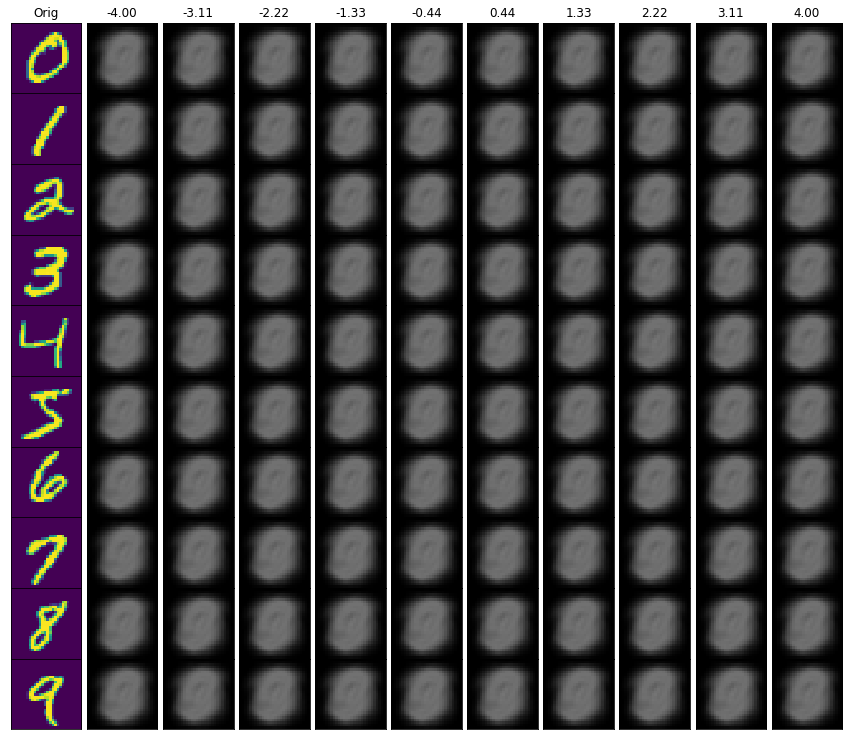

Sweeping reconstructions over latent variable no. 1


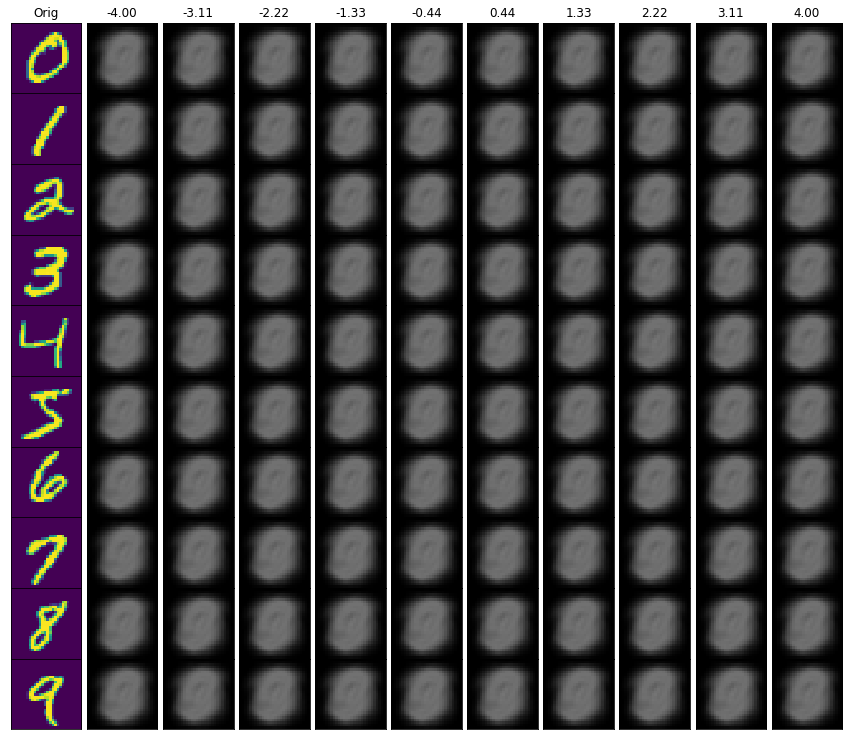

Sweeping reconstructions over latent variable no. 2


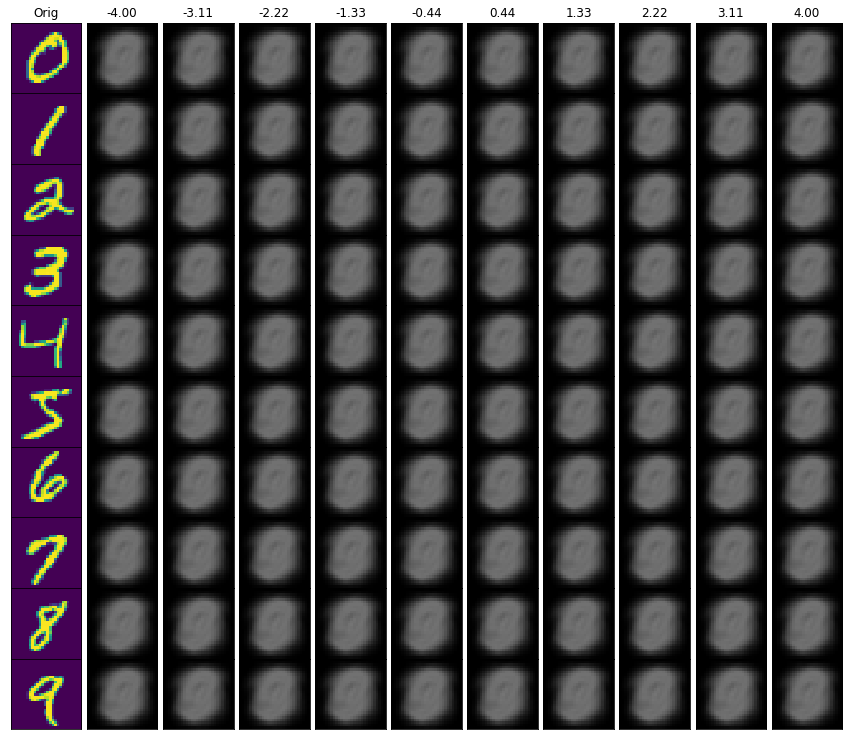

Sweeping reconstructions over latent variable no. 3


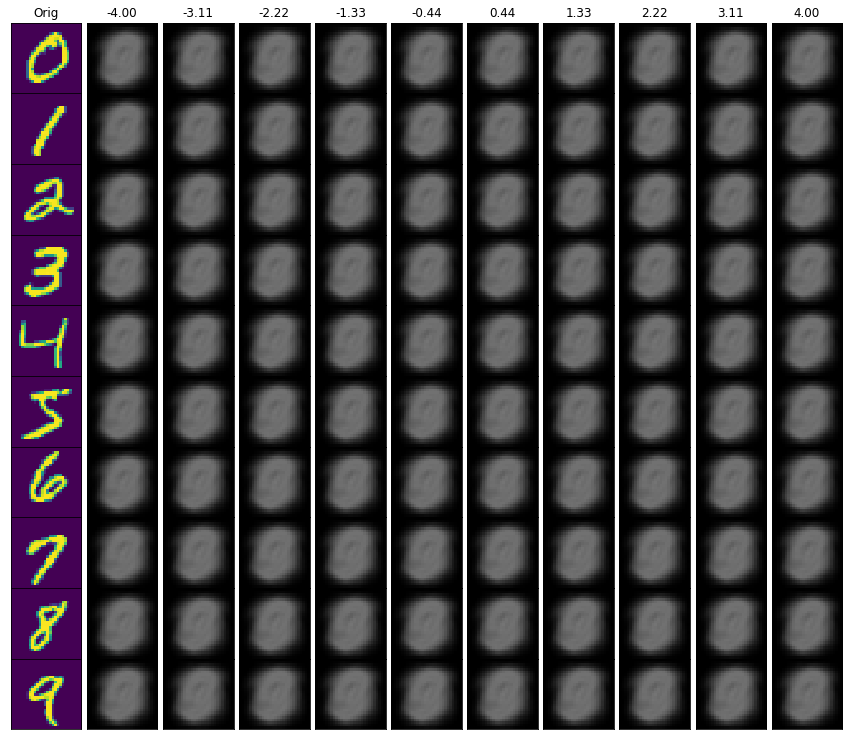

Sweeping reconstructions over latent variable no. 4


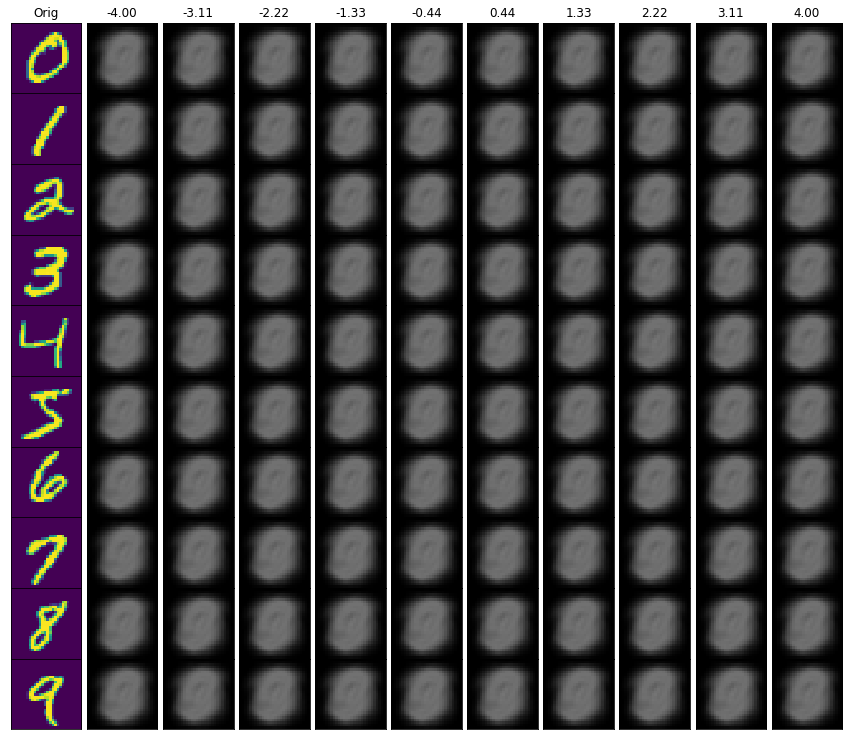

Sweeping reconstructions over latent variable no. 5


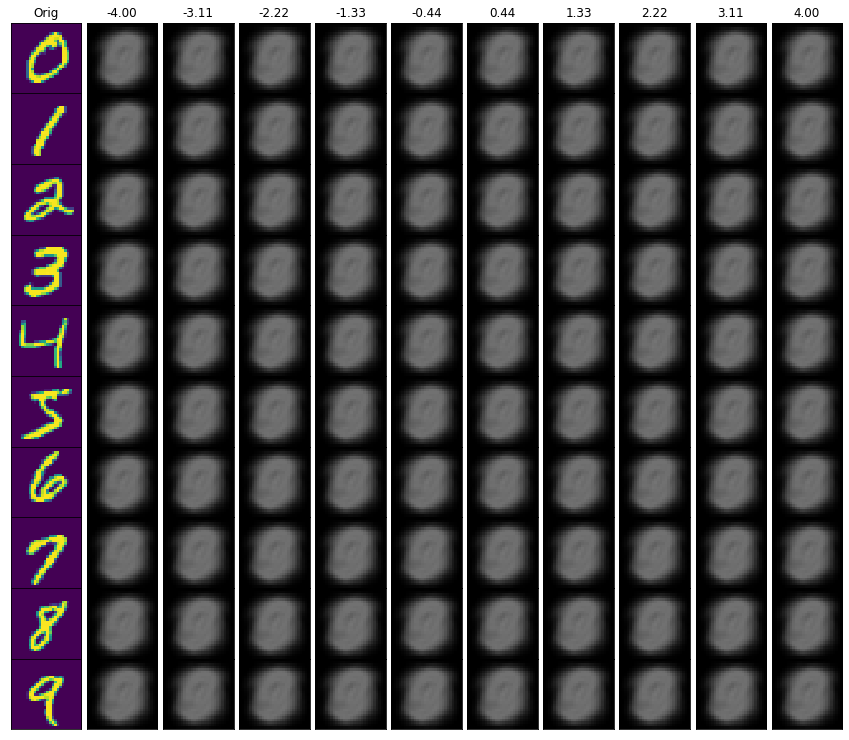

Sweeping reconstructions over latent variable no. 6


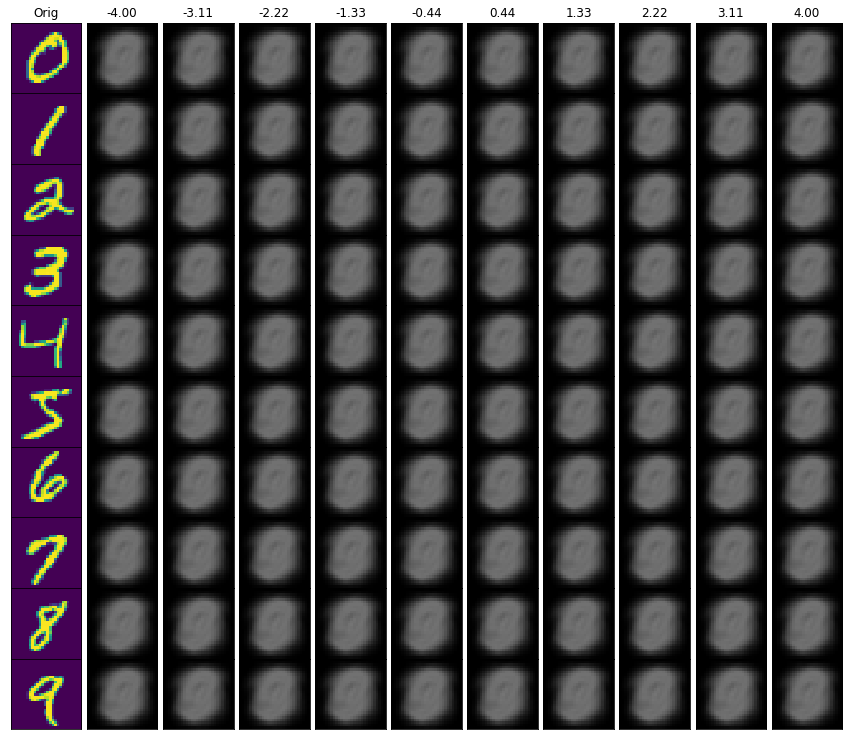

Sweeping reconstructions over latent variable no. 7


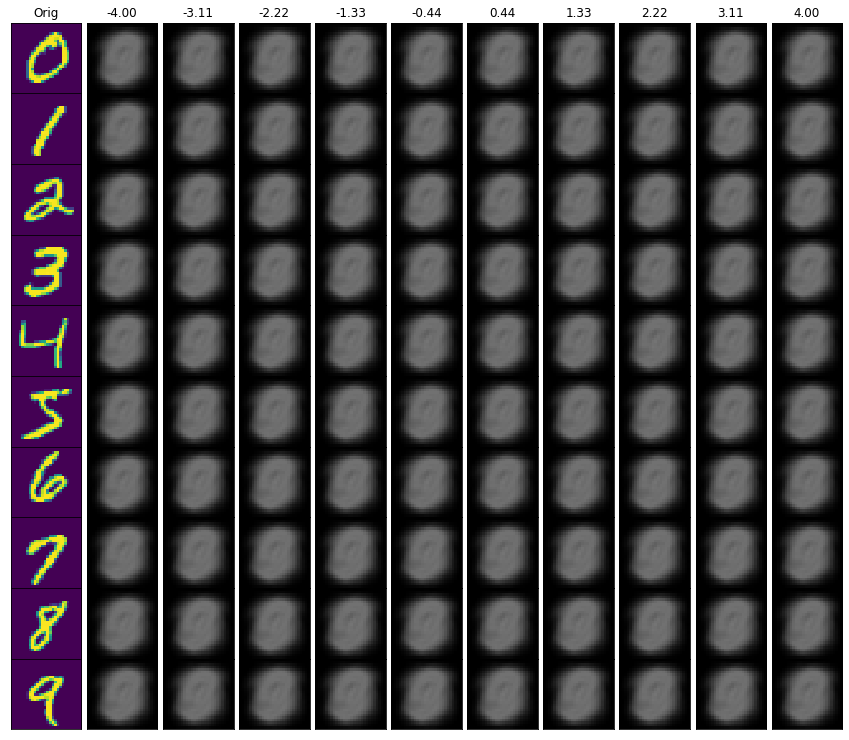

Sweeping reconstructions over latent variable no. 8


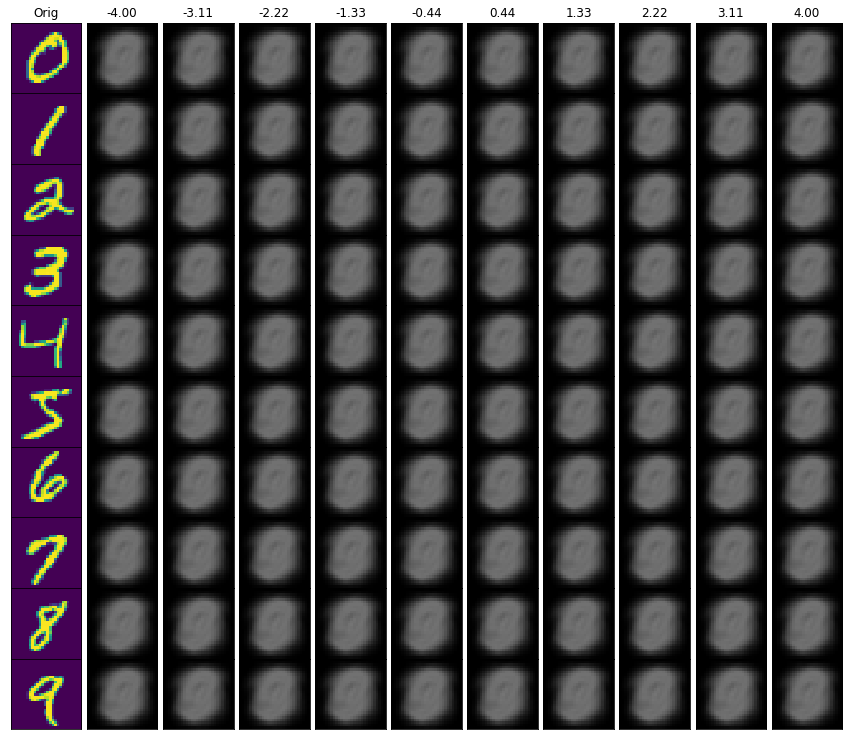

Sweeping reconstructions over latent variable no. 9


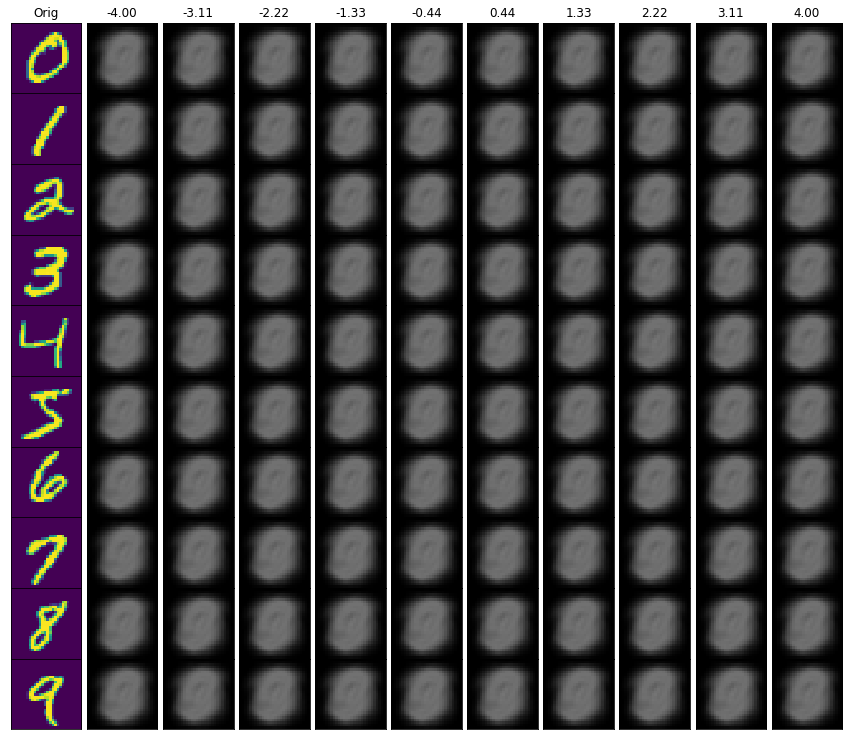

Sweeping reconstructions over latent variable no. 10


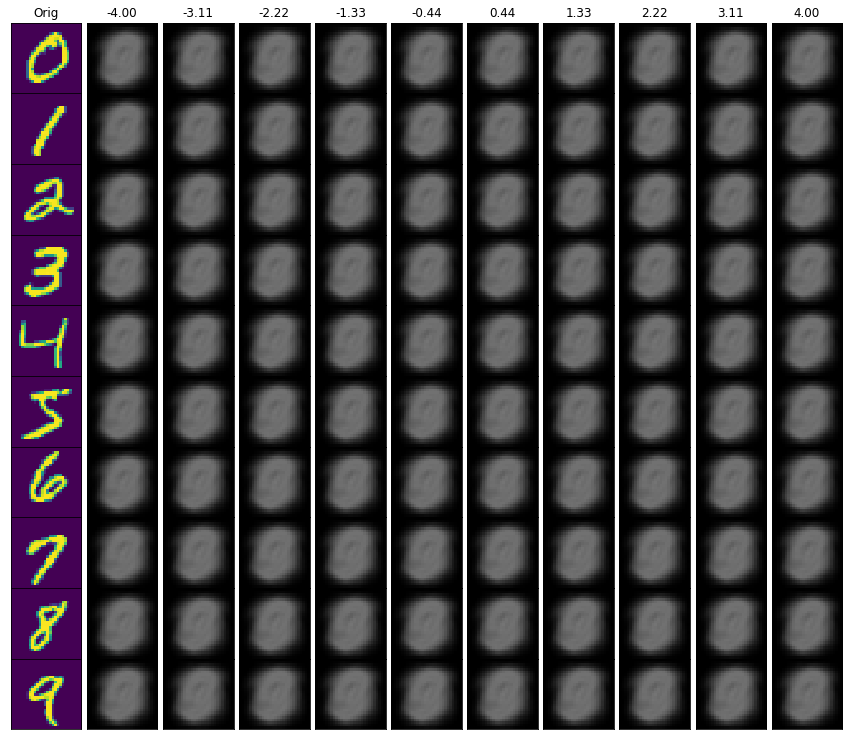

Sweeping reconstructions over latent variable no. 11


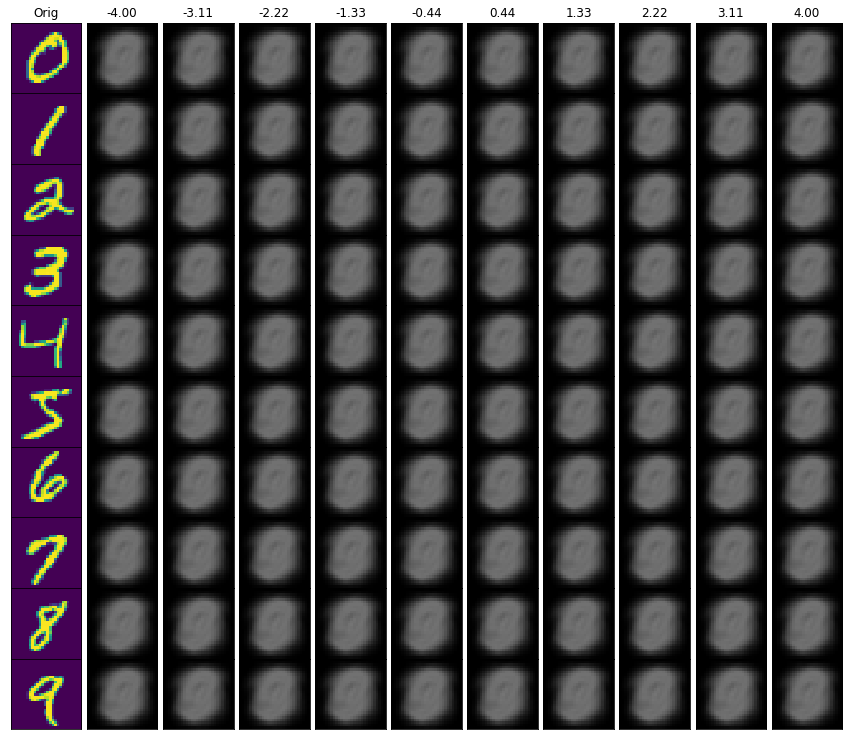

Sweeping reconstructions over latent variable no. 12


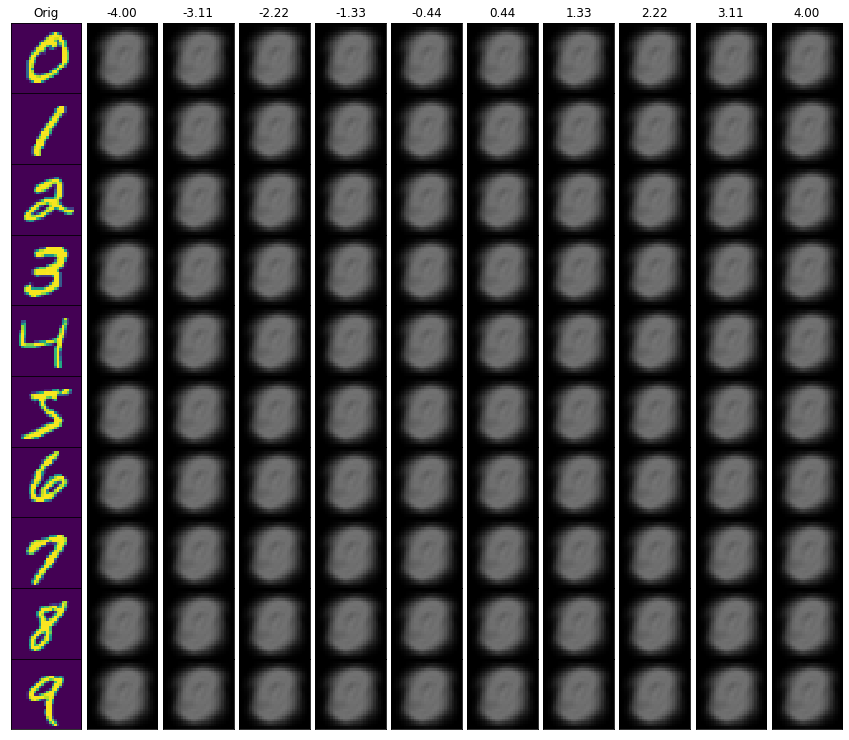

Sweeping reconstructions over latent variable no. 13


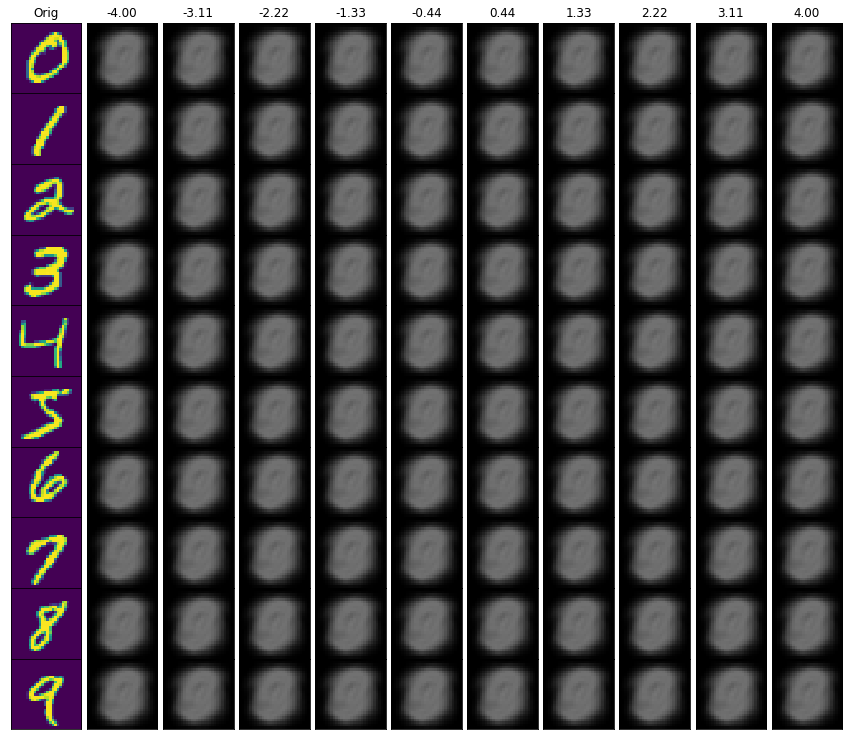

Sweeping reconstructions over latent variable no. 14


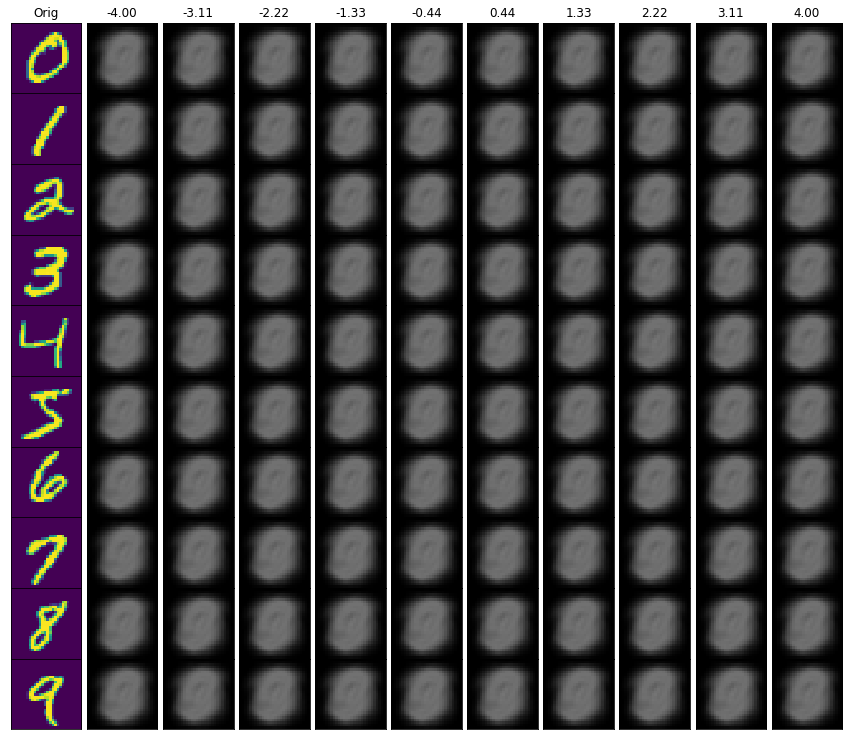

Sweeping reconstructions over latent variable no. 15


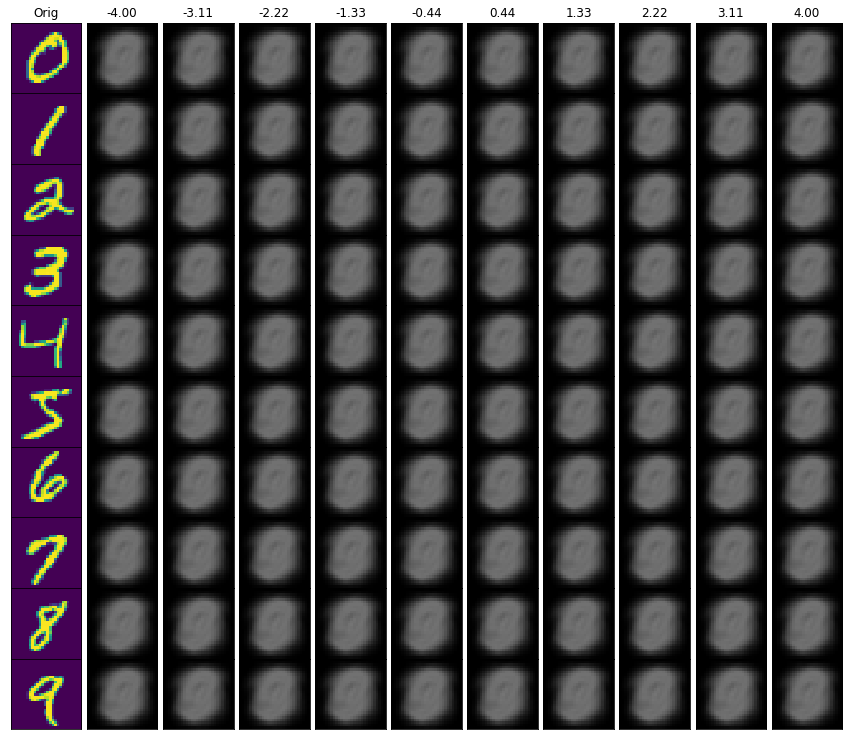

Sweeping reconstructions over latent variable no. 16


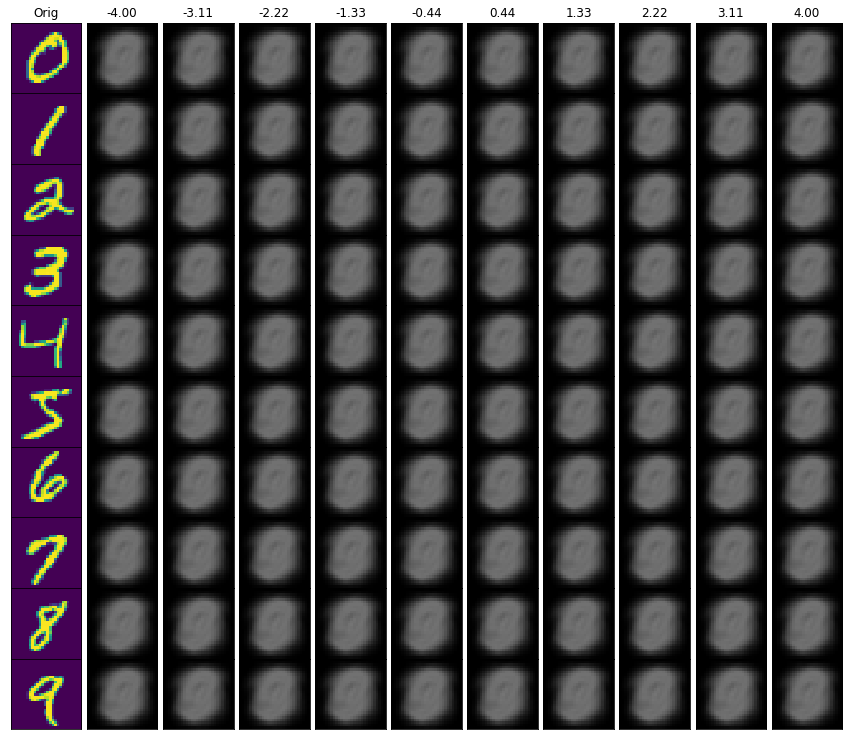

Sweeping reconstructions over latent variable no. 17


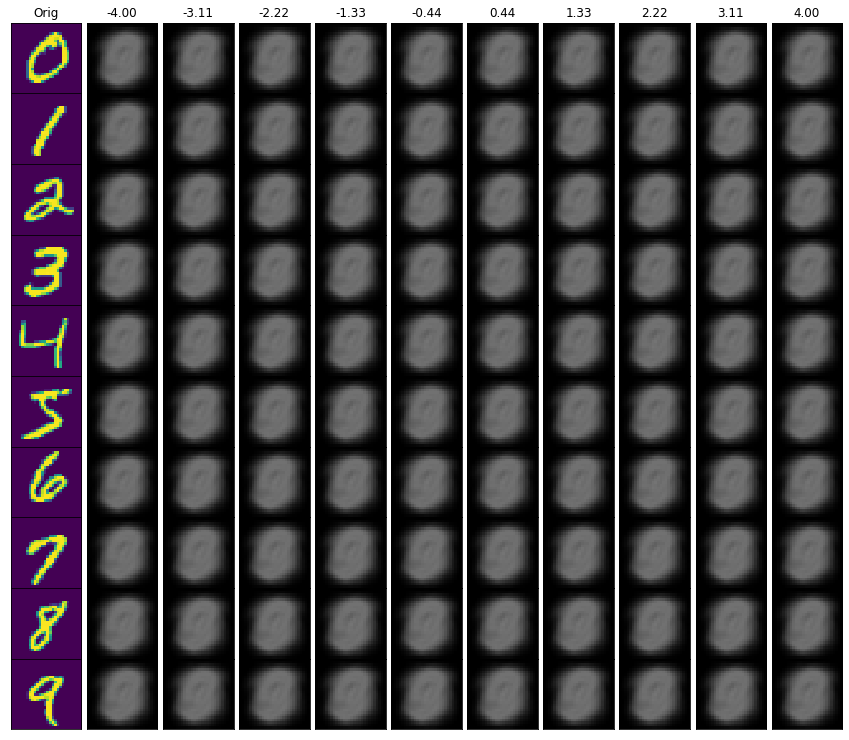

Sweeping reconstructions over latent variable no. 18


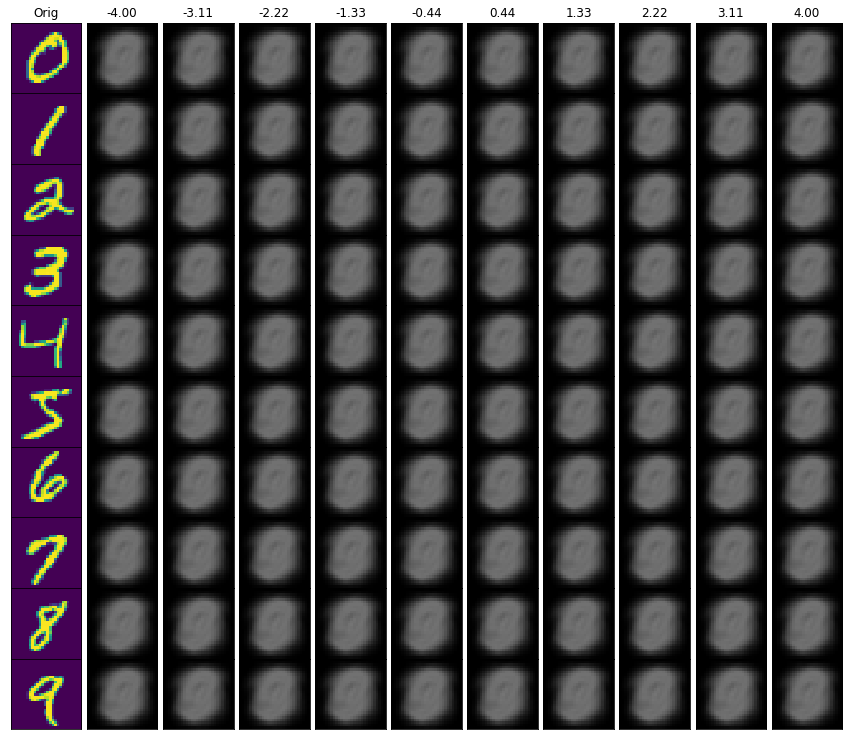

Sweeping reconstructions over latent variable no. 19


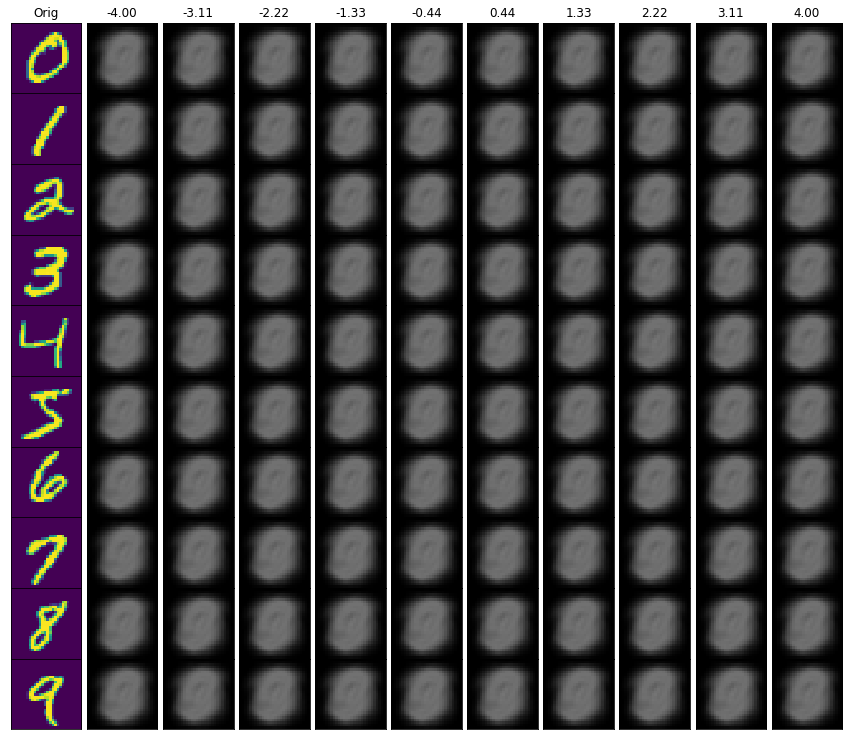

In [17]:
for i in range(20):
    print(f'Sweeping reconstructions over latent variable no. {i}')
    recons_by_var = sweep_variable_across_samples(model.beta_tcvae,
                                                  digit_encodings.clone(),
                                                  i,
                                                  sweep_range)
    plot_sweep_grid(digits.detach().numpy(), recons_by_var, sweep_range)